## Repurposing Topobathy for Swell Data

In [1]:
from pathlib import Path
import numpy as np
from PIL import Image
import psycopg2 as pg
import pandas as pd

Import the color worldmap base image

In [2]:
base_image = "./data/worldColour.5400x2700.jpg"

## Convert Default Topobathy to Numpy array

In [3]:
topobathy = "./data/gebco_bathy.5400x2700_8bit.jpg"
image = Image.open(topobathy).convert('L')
topobathy_arr = np.array(image)

In [4]:
topobathy_arr.shape

(2700, 5400)

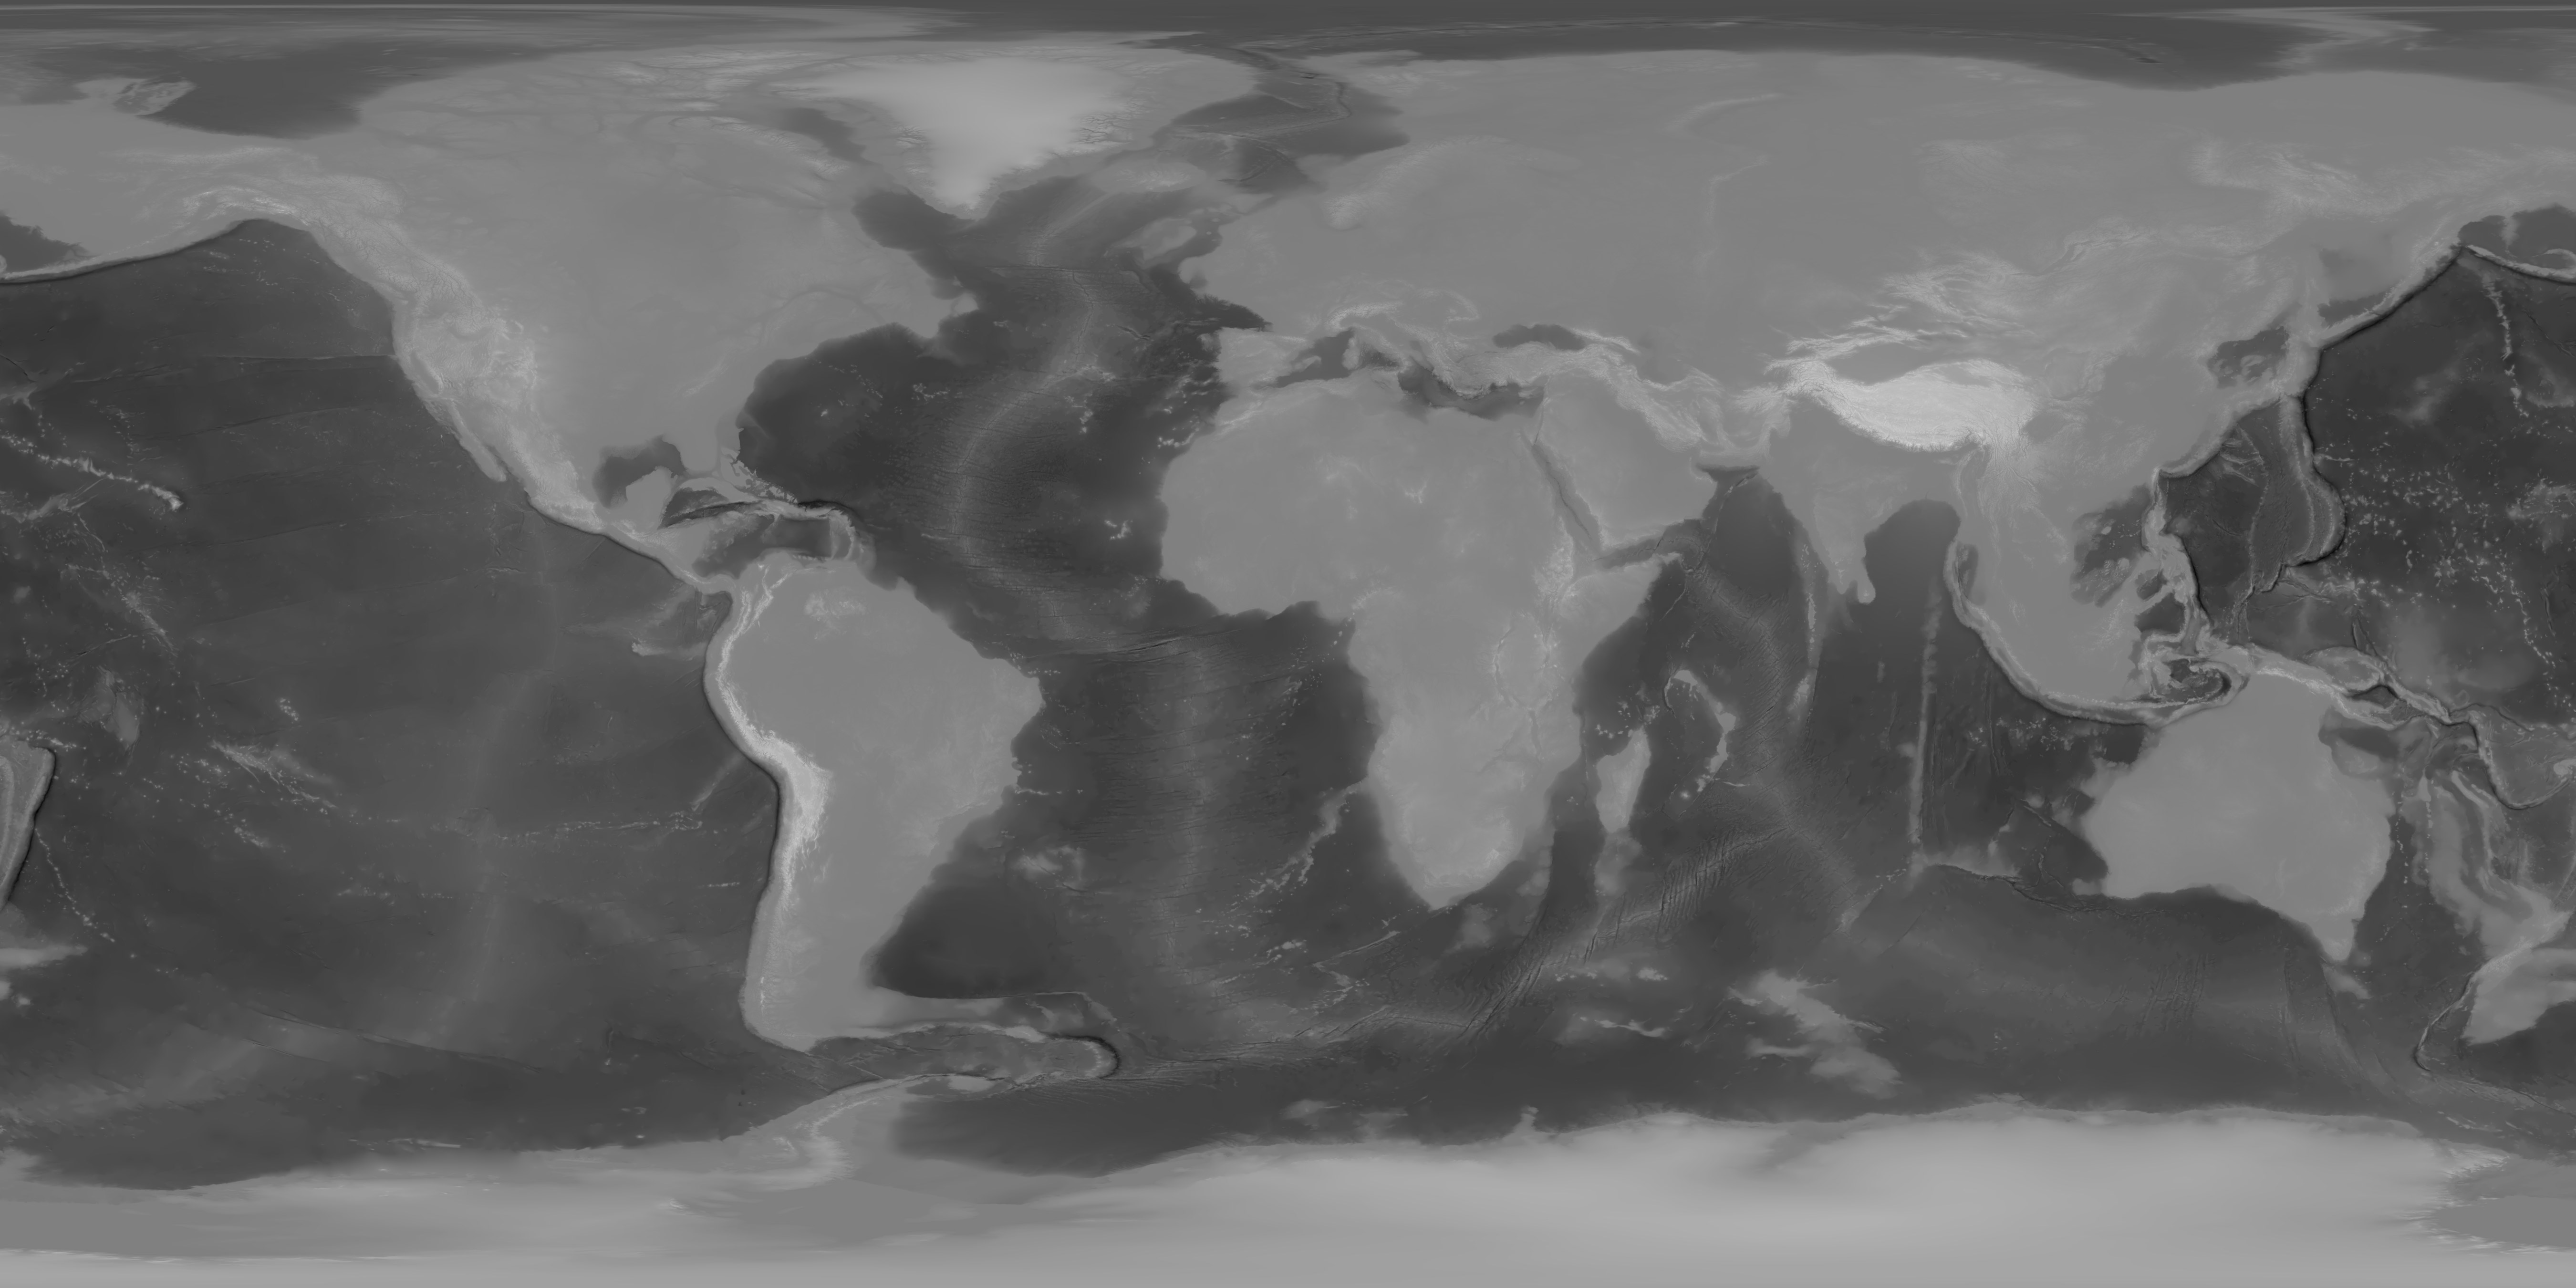

In [5]:
Image.fromarray(topobathy_arr)

In [6]:
topobathy_arr

array([[ 78,  78,  78, ...,  78,  78,  78],
       [ 78,  78,  78, ...,  78,  78,  78],
       [ 78,  78,  78, ...,  78,  78,  78],
       ...,
       [161, 161, 161, ..., 161, 161, 161],
       [161, 161, 161, ..., 161, 161, 161],
       [161, 161, 161, ..., 161, 161, 161]], dtype=uint8)

## Numpy


Get create lat and lon ranges to check size vs our image

In [7]:
lat_range = np.arange(-90, 90.25, 0.25)
lat_range = lat_range[:, None]

lon_range = np.arange(-180, 180, 0.25)
lon_range = lon_range[None, :]
lat_range.shape, lon_range.shape

((721, 1), (1, 1440))

In [8]:
lat_range.max()

90.0

In [9]:
np.array(lat_range@lon_range).shape

(721, 1440)

When comparing our data array to the topobathy image array, it appears that aspect ratio is the same, and that our data is a scaled down match in terms of what we'll need to convert to `pixels`

In [10]:
np.array((lat_range@lon_range).shape) / np.array(topobathy_arr.shape) 

array([0.26703704, 0.26666667])

In [11]:
1440 * 1/.5333333

2700.0001687500103

We will as well have to generate greyscale values as well 

## Connect to Postgres database

#In the postgres db, we have data fetched from the NOAA Wavewatch III forecasts for latitudes and longitudes at #intervals of roughly `0.25`. We want to fetch the swell data so that we can transform it into something useful for #creating a topobathy image.

In [12]:
query = """
SELECT
    COALESCE(swell, 0) as swell, latitude, longitude
FROM wave_forecast
WHERE
    valid_time = '2023-12-08 00:00:00+00'
ORDER BY
    latitude DESC,
    longitude ASC;
"""

In [13]:
dbname = "surfing_data"
user = "postgres"
password = "your_password"
host = "localhost"

In [14]:
def query_database_in_batches(cursor, query, batch_size=1000):
    """Generator function to query the database in batches using a server-side cursor."""
    cursor.execute(query)
    while True:
        records = cursor.fetchmany(batch_size)
        if not records:
            break
        yield [item[0] for item in records]

In [15]:
# # Connect to your PostgreSQL database
# conn = pg.connect(
#     dbname=dbname,
#     user=user,
#     password=password,
#     host=host
# )
# conn.autocommit = True  # Required for server-side cursors


# swell_list = []
# # Create a server-side cursor
# with conn.cursor() as cursor:
#     with conn:
#         for batch_item in query_database_in_batches(cursor, query, batch_size=1000):
#             swell_list.extend(batch_item)

# # Close the database connection
# conn.close()

In [16]:
query = """
SELECT latitude, longitude, swell from wave_forecast WHERE valid_time = '2023-12-08 00:00:00+00';
"""

In [17]:
conn = pg.connect(
    dbname=dbname,
    user=user,
    password=password,
    host=host
)


In [18]:
df = pd.read_sql_query(query, conn)

/tmp/ipykernel_47170/1553155693.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [19]:
df.head()

latitude  longitude  swell
0      90.0       0.00    NaN
1      90.0       0.25    NaN
2      90.0       0.50    NaN
3      90.0       0.75    NaN
4      90.0       1.00    NaN

In [20]:
df['swell'].fillna(0, inplace=True)
df.sort_values(by=['latitude', 'longitude'],
               ascending=[False, True], inplace=True)

In [21]:
df.head()

latitude  longitude  swell
399281      90.0    -180.00    0.0
399282      90.0    -179.75    0.0
399283      90.0    -179.50    0.0
399284      90.0    -179.25    0.0
399285      90.0    -179.00    0.0

In [24]:
def merc_from_arrays(lats, lons):
    r_major = 6378137.000
    x = r_major * np.radians(lons)
    scale = x/lons
    y = 180.0/np.pi * \
        np.log(np.tan(np.pi/4.0 + lats * (np.pi/180.0)/2.0)) * scale
    return (x, y)

In [28]:
lats = df['latitude'].values
lons = df['longitude'].values

In [32]:
lons.min()

-180.0

In [30]:
xs, ys = merc_from_arrays(lats, lons)

/tmp/ipykernel_47170/2842301144.py:4: RuntimeWarning: invalid value encountered in divide
  scale = x/lons
/tmp/ipykernel_47170/2842301144.py:6: RuntimeWarning: divide by zero encountered in log
  np.log(np.tan(np.pi/4.0 + lats * (np.pi/180.0)/2.0)) * scale


In [22]:
swell_arr = df['swell'].to_numpy()

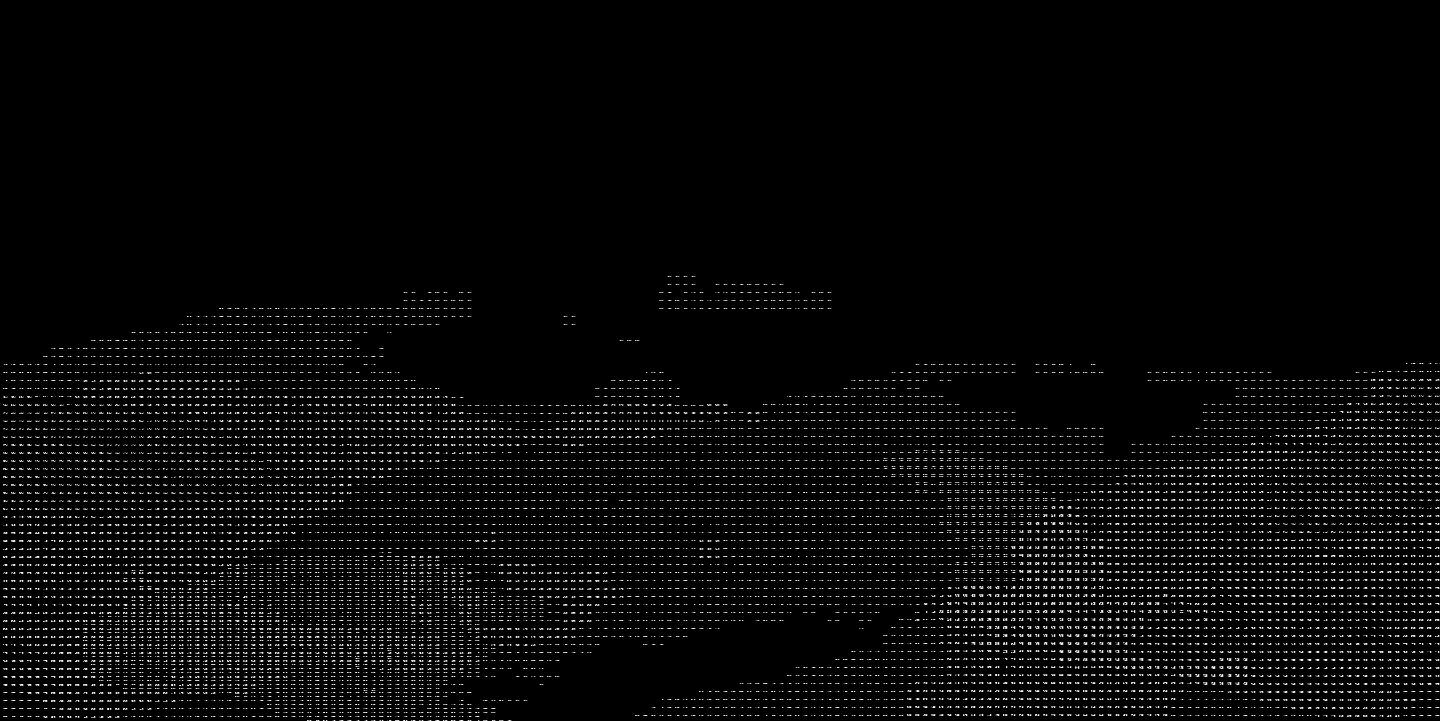

In [23]:
Image.fromarray(swell_arr.reshape(721, 1440), 'L')

Normalize the array

In [ ]:
np.set_printoptions(precision=2, suppress=True)

In [ ]:
np.array(lat_range@lon_range).size

In [ ]:
norm_arr.max()

In [ ]:
norm_arr = (swell_arr - swell_arr.min()) / (swell_arr.max() - swell_arr.min())

In [ ]:
reshaped_norm_arr = norm_arr.reshape(721, 1440)

In [ ]:
reshaped_norm_arr.shape

In [ ]:
swell_image = Image.fromarray(reshaped_norm_arr, 'L')

In [ ]:
swell_image

In [ ]:
Image.fromarray(topobathy_arr)

In [ ]:
upscaled_image = swell_image.resize(topobathy_arr.T.shape, Image.LANCZOS)

In [ ]:
upscaled_image.size

In [ ]:
upscaled_image

In [ ]:
upscaled_image.save("../../three-frontend/dist/client/img/swellBathy.5400x2700.jpg")